In [13]:
!pip install --upgrade datasets==3.6.0 && pip install librosa torch matplotlib transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 573.7 kB/s  0:00:21m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 1.8 MB/s  0:00:0036m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.3 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 3.5 MB/s  0:00:00m0:00:01
  Attempting uninstall: huggingface-hub━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [regex]
    Found existing installation: huggingface_hub 1.1.7━━━━━━━━ 1/5 [regex]
    Uninstalling huggingface_hub-1.1.7:━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [regex]
      Successfully uninstalled huggingface_hub-1.1.7━━━━━━━━━━ 1/5 [regex]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [transformers] [transformers]ub]


In [15]:
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import os
from IPython.display import Audio
import sys # Required for sys.getsizeof
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random # only used for picking random records from the dataset

In [16]:
def transform_fleurs_internal(batch):
        batch['id'] = str(batch['id'])
        batch['gender'] = str(batch['gender'])
        batch['language'] = str(batch['language'])
        return batch

def transform_voxpopuli_internal(batch):
    batch['id'] = batch['audio_id']
    batch['transcription'] = batch['normalized_text']
    batch['language'] = str(batch['language'])
    return batch

def load_train_data():
    # Define columns to keep in the final harmonized schema
    columns_to_keep = ['id', 'audio', 'transcription', 'language', 'gender']

    # Dataset 1: Fleurs
    fleurs_en = load_dataset("google/fleurs", "en_us", split="train", trust_remote_code=True, streaming=True)
    fleurs_ar = load_dataset("google/fleurs", "ar_eg", split="train", trust_remote_code=True, streaming=True)
    fleurs_tr = load_dataset("google/fleurs", "tr_tr", split="train", trust_remote_code=True, streaming=True)

    # Dataset 2: Voxpopuli (Only Supports English)
    voxpopuli_en = load_dataset("facebook/voxpopuli", "en", split="train", trust_remote_code=True, streaming=True)

    # ******************************ENGLISH TRANSFORMATIONS******************************

    # Apply transformations to fleurs_en_dataset
    fleurs_en_transformed = fleurs_en.map(
        transform_fleurs_internal,
        remove_columns=[col for col in fleurs_en.features if col not in columns_to_keep and col != 'audio'],
        batched=False
    )

    # Apply transformations to voxpopuli_en_dataset
    voxpopuli_en_transformed = voxpopuli_en.map(
        transform_voxpopuli_internal,
        remove_columns=[col for col in voxpopuli_en.features if col not in columns_to_keep and col != 'audio'],
        batched=False
    )

    # ******************************ARABIC TRANSFORMATIONS******************************

    # Apply transformations to fleurs_ar_dataset
    fleurs_ar_transformed = fleurs_ar.map(
        transform_fleurs_internal,
        remove_columns=[col for col in fleurs_ar.features if col not in columns_to_keep and col != 'audio'],
        batched=False
    )

    # ******************************TURKISH TRANSFORMATIONS******************************

    # Apply transformations to fleurs_tr_dataset
    fleurs_tr_transformed = fleurs_tr.map(
        transform_fleurs_internal,
        remove_columns=[col for col in fleurs_tr.features if col not in columns_to_keep and col != 'audio'],
        batched=False
    )

    # Combine datasets for each language
    combined_en = concatenate_datasets([fleurs_en_transformed, voxpopuli_en_transformed])
    combined_ar = concatenate_datasets([fleurs_ar_transformed])
    combined_tr = concatenate_datasets([fleurs_tr_transformed])

    return {"en": combined_en, "ar": combined_ar, "tr": combined_tr}

In [17]:
def play_audio(record):
  return Audio(data=record['audio']['array'], rate=record['audio']['sampling_rate'])

In [18]:
dataset = load_train_data()
english_dataset = dataset['en']

random_seed = random.randint(0, 1000000)
shuffled_english_dataset = english_dataset.shuffle(seed=random_seed)
english_audio_record = next(iter(shuffled_english_dataset))

play_audio(english_audio_record)

HTTP Error 504 thrown while requesting GET https://huggingface.co/datasets/facebook/voxpopuli/resolve/719aaef8225945c0d80b277de6c79aa42ab053d5/data/en/train/train_part_0.tar.gz
Retrying in 1s [Retry 1/5].
HTTP Error 504 thrown while requesting GET https://huggingface.co/datasets/facebook/voxpopuli/resolve/719aaef8225945c0d80b277de6c79aa42ab053d5/data/en/train/train_part_0.tar.gz
Retrying in 2s [Retry 2/5].
HTTP Error 504 thrown while requesting GET https://huggingface.co/datasets/facebook/voxpopuli/resolve/719aaef8225945c0d80b277de6c79aa42ab053d5/data/en/train/train_part_0.tar.gz
Retrying in 4s [Retry 3/5].


KeyboardInterrupt: 

Spectrogram shape: (1025, 93)
Spectogram Object: [-80.         -80.         -80.         -80.         -80.
 -80.         -80.         -80.         -80.         -78.06883931]


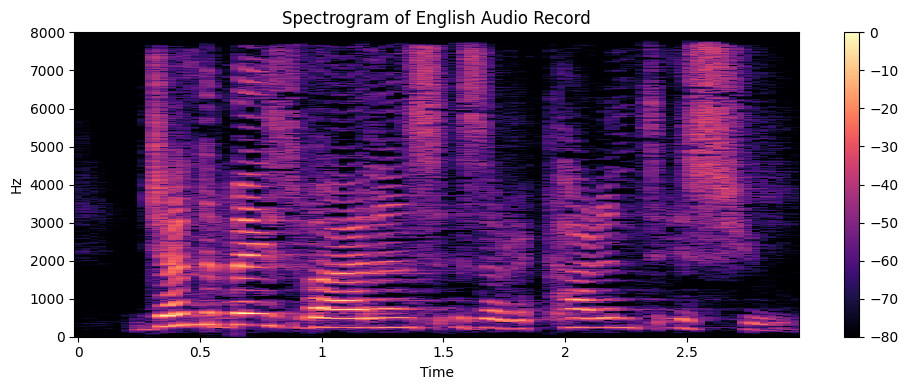

In [ ]:
def SpectogramEncoder(audio_array, sampling_rate):
    """
    Converts an audio array to a spectrogram.

    Args:
        audio_array (np.ndarray): The audio time series.
        sampling_rate (int): The sampling rate of the audio.

    Returns:
        np.ndarray: The spectrogram in dB scale.
    """
    # Compute the Short-Time Fourier Transform (STFT)
    D = librosa.stft(audio_array)
    # Convert amplitude spectrogram to dB-scaled spectrogram
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_db

# Example usage with the previously loaded english_audio_record
audio_array = np.array(english_audio_record['audio']['array'])
sampling_rate = english_audio_record['audio']['sampling_rate']

spectrogram = SpectogramEncoder(audio_array, sampling_rate)

print("Spectrogram shape:", spectrogram.shape)
print("Spectogram Object:", spectrogram[1][:10])

# Optionally, display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Spectrogram of English Audio Record')
plt.tight_layout()
plt.show()

Using the pretrained model "Wav2Vec 2.0" developed by Facebook/Meta. This model has already been trained on thousands of hours of speech and knows how to extract rich feature vectors from waveforms.

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import librosa

class Wav2VecEncoder(nn.Module):
    def __init__(self, model_name="facebook/wav2vec2-base-960h"):
        super(Wav2VecEncoder, self).__init__()

        # 1. Load the Processor (Handles resampling and normalization logic)
        self.processor = Wav2Vec2Processor.from_pretrained(model_name)

        # 2. Load the Model (The neural network with pretrained weights)
        # We use Wav2Vec2Model (not ForCTC) because you want the vectors/hidden states, not text.
        self.model = Wav2Vec2Model.from_pretrained(model_name)

        # Freezing the model (Optional):
        # If you only want to EXTRACT features and not train the wav2vec part,
        # un-comment the loop below. For now, we leave it trainable or strictly for extraction.
        # for param in self.model.parameters():
        #     param.requires_grad = False

    def forward(self, input_values):
        # Pass inputs through the model
        outputs = self.model(input_values)

        # .last_hidden_state contains the vector representations (Z)
        # Shape: (Batch_Size, Sequence_Length, Hidden_Size)
        return outputs.last_hidden_state

In [ ]:
# 1. Instantiate the pretrained model
feature_encoder = Wav2VecEncoder(model_name="facebook/wav2vec2-base-960h")

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_encoder.to(device)

try:
    # 2. Get the audio data
    # FIX: We wrap this in np.array() to ensure it is not a list
    raw_audio_numpy = np.array(english_audio_record['audio']['array'])
    orig_sampling_rate = english_audio_record['audio']['sampling_rate']

    # --- RESAMPLING ---
    target_sampling_rate = 16000

    if orig_sampling_rate != target_sampling_rate:
        print(f"Resampling from {orig_sampling_rate}Hz to {target_sampling_rate}Hz...")
        audio_input = librosa.resample(y=raw_audio_numpy, orig_sr=orig_sampling_rate, target_sr=target_sampling_rate)
    else:
        audio_input = raw_audio_numpy

    # 3. Preprocessing
    inputs = feature_encoder.processor(audio_input, sampling_rate=target_sampling_rate, return_tensors="pt")
    input_values = inputs.input_values.to(device)

    # 4. Generate the Vectors
    with torch.no_grad():
        generated_vectors = feature_encoder(input_values)

    # 5. Inspect the Output
    print(f"\nOriginal Audio Shape (Resampled): {audio_input.shape}")
    print(f"Generated Vector Shape: {generated_vectors.shape} (Batch, Latent_Time, Features)")

    print("\nThese are the Pretrained Wav2Vec latent representations.")
    print("First 10 features of the first time step:")
    print(generated_vectors[0, 0, :10])

except Exception as e:
    print(f"An error occurred: {e}")
    # This helps us debug if it happens again
    import traceback
    traceback.print_exc()

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original Audio Shape (Resampled): (47344,)
Generated Vector Shape: torch.Size([1, 147, 768]) (Batch, Latent_Time, Features)

These are the Pretrained Wav2Vec latent representations.
First 10 features of the first time step:
tensor([-0.0374,  0.0491, -0.1219, -0.0239, -0.0462, -0.0990,  0.1920, -0.0462,
         0.1864, -0.3253])


Using the pretrained model Vector Quantized Generative Adversarial Network "VQ-GAN"(known as EnCodec) developed by Meta. Uses Vector Quantization to compress Input Audio Waveform(the audio file / the speech signal).

In [ ]:
from transformers import EncodecModel, AutoProcessor

class VQGANEncoder(nn.Module):
    def __init__(self, model_name="facebook/encodec_24khz"):
        super(VQGANEncoder, self).__init__()

        # 1. Load the Processor (Handles resampling logic internally)
        self.processor = AutoProcessor.from_pretrained(model_name)

        # 2. Load the Model (This acts as the VQ-GAN)
        self.model = EncodecModel.from_pretrained(model_name)

    def encode(self, input_values, bandwidth=None):
        # Turns Audio -> Discrete Codes
        # Result shape: (Batch, Frames, Codebooks)
        return self.model.encode(input_values, bandwidth=bandwidth)

    def decode(self, audio_codes, audio_scales=None):
        # Turns Discrete Codes -> Audio
        # We generally don't need scales for simple reconstruction in recent versions,
        # but the model expects the argument structure.
        return self.model.decode(audio_codes, audio_scales)[0]

In [ ]:
# 1. Instantiate the VQ-GAN (EnCodec)
vqgan_model = VQGANEncoder(model_name="facebook/encodec_24khz")
vqgan_model.to(device)

try:
    # 2. Prepare Data (EnCodec expects 24kHz)
    raw_audio_numpy = np.array(english_audio_record['audio']['array'])
    orig_sampling_rate = english_audio_record['audio']['sampling_rate']
    target_sampling_rate = 24000

    # Resample
    if orig_sampling_rate != target_sampling_rate:
        print(f"Resampling for VQ-GAN from {orig_sampling_rate}Hz to {target_sampling_rate}Hz...")
        audio_input = librosa.resample(y=raw_audio_numpy, orig_sr=orig_sampling_rate, target_sr=target_sampling_rate)
    else:
        audio_input = raw_audio_numpy

    # 3. Preprocess (Add Batch and Channel dimensions)
    # EnCodec expects: (Batch, Channels, Time) -> (1, 1, Time)
    inputs = vqgan_model.processor(raw_audio=audio_input, sampling_rate=target_sampling_rate, return_tensors="pt")
    input_values = inputs["input_values"].to(device)

    # 4. ENCODE: Audio -> Discrete Codes
    # This is the "VQ" part. We get a list of integers.
    with torch.no_grad():
        # Change 'bandwidth' here to: 1.5, 3.0, 6.0, 12.0, or 24.0. The greater the bandwidth, the better the audio output but more latent codes generated.
        # As the sequence of numbers becomes too long and complex, and the "Bridge" translation model will struggle to learn it later.
        # For example, At 1.5 kbps: For every time step, the bridge only needs to predict 2 numbers. At 24.0 kbps: For every time step, the bridge must predict 32 numbers
        encoder_outputs = vqgan_model.encode(input_values, bandwidth=6.0)
        audio_codes = encoder_outputs.audio_codes
        audio_scales = encoder_outputs.audio_scales

    # 5. DECODE: Discrete Codes -> Audio
    # This is the "GAN" part (Generator). It reconstructs sound from the numbers.
    with torch.no_grad():
        reconstructed_audio = vqgan_model.decode(audio_codes, audio_scales)

    # 6. Inspect Results
    print(f"\nOriginal Audio Shape: {input_values.shape}")
    print(f"Compressed Codes Shape: {audio_codes.shape} (Batch, Codebooks, Time_Frames)")

    print("\nThese are the Discrete Codes (The 'Language' of the Audio):")
    # We look at the first codebook, first 10 time steps
    print(audio_codes[0, 0, :20])

    # 7. Listen to the Result
    # If the VQ-GAN is working, this should sound almost identical to the original.
    print("\nPlaying Reconstructed Audio (Decoded from codes):")
    display(Audio(data=reconstructed_audio.cpu().numpy().squeeze(), rate=target_sampling_rate))

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

preprocessor_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/93.1M [00:00<?, ?B/s]

Resampling for VQ-GAN from 16000Hz to 24000Hz...

Original Audio Shape: torch.Size([1, 1, 71016])
Compressed Codes Shape: torch.Size([1, 1, 8, 222]) (Batch, Codebooks, Time_Frames)

These are the Discrete Codes (The 'Language' of the Audio):
tensor([[  62,  835,  408,  ...,  738,  738,  738],
        [ 544,  646,  544,  ...,  424,  700,  544],
        [ 786,  937,  786,  ...,  982,  937,   36],
        ...,
        [1011,  293,  701,  ...,  632,  632, 1011],
        [1002,  900,  900,  ...,  908,  485,  853],
        [ 899,  878,  899,  ...,  475,  975,  975]])

Playing Reconstructed Audio (Decoded from codes):
